# Building Artificial Neural Networks

Artificial Neural Networks (ANNs), also known as neural networks (NNs), in the fields of machine learning and cognitive science, are mathematical or computational models that mimic the structure and function of biological neural networks (especially the central nervous system of animals, particularly the brain) for estimating or approximating functions. Similar to how neurons in the human brain are interconnected, neurons in an artificial neural network are also interconnected in various layers of the network.

Compared to spiking neural networks, the neurons in artificial neural networks are simplified and do not have intrinsic dynamics. The information transmitted between neurons is not discrete action potentials (0 or 1), but continuous floating-point numbers, which can be understood as the firing rate of a neuron at a given time step. Although artificial neural networks were originally inspired by biological brains and can exhibit some properties of biological brains, they are primarily used as powerful models to solve specific problems without focusing on how their parts correspond to biological systems.

<center>
    <img src="../../_static/images/artificial-neural-network-tutorial1.png" alt="bnn" />
</center>
<center>
    <img src="../../_static/images/artificial-neural-network-tutorial2.png" alt="ann" />
</center>

## Architecture of Artificial Neural Networks

The neurons in artificial neural networks are distributed across different layers, and information propagates forward layer by layer. These layers can be categorized into three types:

- Input Layer: The first layer of the artificial neural network, which receives input and passes it to the hidden layers.
- Hidden Layers: These layers perform various computations and feature extraction on the input received from the input layer. Typically, there are multiple hidden layers through which the information flows sequentially.
- Output Layer: Finally, the output layer receives information from the hidden layers, performs computations, and provides the final result.

<center>
    <img src="../../_static/images/artificial-neural-network-tutorial3.png" alt="ann2" />
</center>

Depending on the type of computation, there are many different kinds of layers in an artificial neural network. The simplest type of layer is the linear layer. After receiving the input, the linear layer computes the weighted sum of the inputs, adds a bias term, and produces the output. This can be expressed by the formula:
$$
\sum_{\mathrm{i=1}}^{\mathrm{n}}\mathrm{W_i}*\mathrm{X_i}+\mathrm{b}。\tag{1}
$$
This dot product and summation are linear operations. If more layers are added but only linear operations are used, adding layers will have no effect, as they can be equivalently reduced to a single linear transformation due to the commutative and associative properties. Therefore, we need to add a nonlinear **activation function** to increase the expressive power of the model. The activation function determines whether a neuron is activated. Only activated neurons will have (non-zero) outputs, which is analogous to biological neurons. There are various types of activation functions to choose from, depending on the task. In the neural network implementation in this tutorial, we will use ReLU (Rectified Linear Unit) and Softmax activation functions, which will be explained in more detail later.

## Workflow of Artificial Neural Networks

Artificial neural networks are data-driven statistical models. We train the model to solve problems not by explicitly writing rules, but by providing training data and allowing the model to learn the solution method.

Specifically, we provide a dataset that specifies the input-output relationship, run the model to obtain its current output, and use the **loss function** to compute the difference between the model’s output and the correct output. Then, using the **backpropagation** method, we compute the partial derivatives of the parameters (mainly weights $W$ and biases $b$) layer by layer to obtain the magnitude and direction of parameter optimization. Finally, the **optimizer** is used to optimize the parameters so that the model’s output is as close as possible to the standard output provided by the dataset.

## Building Your First Artificial Neural Network

Here, we will use `brainstate` to write code to construct a 3-layer Multilayer Perceptron (MLP) for a handwritten digit recognition (MNIST) task as an example.

We will input handwritten digit images into the constructed MLP and have the network output the digit represented by each image.

<center>
    <img src="../../_static/images/artificial-neural-network-tutorial5.jpg" alt="mnist mlp" />
</center>


In [ ]:
import jax.numpy as jnp
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

import brainstate 
from braintools.metric import softmax_cross_entropy_with_integer_labels

In [2]:
brainstate.__version__

'0.2.2'

## Preparing the Dataset

First, prepare the dataset. The dataset provides many corresponding "input-output" samples. In this task, the input is the image of the handwritten digit, and the output is the label of the digit.

The dataset can be divided into a training set and a test set (with no overlap between the two). The model is trained on the training set, adjusting the model's parameters, while the test set is used to evaluate the model's performance without updating parameters.

In [3]:
dataset = load_dataset('mnist')
X_train = np.array(np.stack(dataset['train']['image']), dtype=np.uint8)
X_test = np.array(np.stack(dataset['test']['image']), dtype=np.uint8)
X_train = (X_train > 0).astype(jnp.float32)
X_test = (X_test > 0).astype(jnp.float32)
Y_train = np.array(dataset['train']['label'], dtype=np.int32)
Y_test = np.array(dataset['test']['label'], dtype=np.int32)

The MNIST training set contains 60,000 samples, and the test set contains 10,000 samples. Each sample is a $28 \times 28$ grayscale image, and the output is a single label.

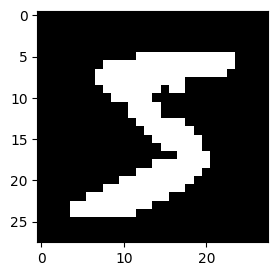

5


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0], cmap='gray')
plt.show()
print(Y_train[0])
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

For convenience, we need to wrap the dataset into a `Dataset` class for unified processing.

In [5]:
class Dataset:
    def __init__(self, X, Y, batch_size, shuffle=True):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        # Check if all samples have been processed
        if self.current_index >= len(self.X):
            raise StopIteration

        # Define the start and end of the current batch
        start = self.current_index
        end = start + self.batch_size
        if end > len(self.X):
            end = len(self.X)
        
        # Update current index
        self.current_index = end

        # Select batch samples
        batch_indices = self.indices[start:end]
        batch_X = self.X[batch_indices]
        batch_Y = self.Y[batch_indices]

        # Ensure batch has consistent shape
        if batch_X.ndim == 1:
            batch_X = np.expand_dims(batch_X, axis=0)

        return batch_X, batch_Y

During training, the data is generally divided into batches, which are input into the model. The model computes the loss for all samples in a batch and performs gradient backpropagation to optimize the parameters.

Training the entire dataset at once would require excessive GPU memory, and training on just one sample at a time would lead to inefficient parallelization, excessive training time, and each parameter update containing information from only a single sample, which is not ideal for convergence over the entire dataset. Using batches is a good balance. Since the test set does not require parameter updates, a larger batch size can be used, depending on the available GPU memory.

The training set is generally shuffled (`shuffle=True`) to ensure that each iteration of the training process has different sample combinations, which helps the model converge over the entire dataset. Since the test set does not update parameters, shuffling is not required.

In [6]:
# Initialize training and testing datasets
batch_size = 32
train_dataset = Dataset(X_train, Y_train, batch_size, shuffle=True)
test_dataset = Dataset(X_test, Y_test, batch_size, shuffle=False)

## Defining the Model Structure

A classic MLP consists of three linear layers: one input layer, one hidden layer, and one output layer.

When defining each linear layer, we need to specify the input and output dimensions of the layer (this is straightforward as the size of $W$ is determined by equation (1)):

- The linear layer only accepts 1D input, so we use the `flatten()` function to convert the 2D image into a 1D vector. Here, $28*28=784$ is the size of the input to the first linear layer.
- Handwritten digit recognition is a 10-class classification task, so the output of the model should be a 10-dimensional vector, with each dimension representing the probability of each digit. Therefore, the output dimension of the final linear layer is $10$.
- The hidden layer extracts features from the input, with larger dimensions corresponding to more features and greater expressive power. In this simple task, the hidden layer dimension can be set to a value between $784$ and $10$. If the performance is not satisfactory, the hidden layer dimension can be increased. In more complex tasks, the number of hidden layers can be increased, and the dimensions of hidden layers can exceed the input and output sizes. However, the dimensions of hidden layers generally increase first and then decrease layer by layer.
- Note that for adjacent layers, the output dimension of the previous layer is the input dimension of the next layer.

<center>
    <img src="../../_static/images/artificial-neural-network-tutorial5.jpg" alt="mnist mlp" />
</center>

As mentioned earlier, activation functions need to be added between linear layers, otherwise the model would be equivalent to a single linear layer. In this example, we use the ReLU (Rectified Linear Unit) activation function, which sets negative values to zero, introducing nonlinearity. The formula for ReLU is:
$$
\text{ReLU}(x) = \max(0, x)\tag{2}
$$

<center>
    <img src="../../_static/images/artificial-neural-network-tutorial4.png" alt="relu" />
</center>


In [7]:
# Define MLP model
class MLP(brainstate.nn.Module):
  def __init__(self, din, dhidden, dout):
    super().__init__()
    self.linear1 = brainstate.nn.Linear(din, dhidden)   # Define the first linear layer, input dimension is din, output dimension is dhidden       
    self.linear2 = brainstate.nn.Linear(dhidden, dhidden)   # Define the second linear layer, input dimension is dhidden, output dimension is dhidden
    self.linear3 = brainstate.nn.Linear(dhidden, dout)    # Define the third linear layer, input dimension is dhidden, output dimension is dout (10 classes for MNIST)
    self.flatten = brainstate.nn.Flatten(start_axis=1)   # Flatten images to 1D
    self.relu = brainstate.nn.ReLU()   # ReLU activation function

  def __call__(self, x):
    x = self.flatten(x)  # Flatten the input image from 2D to 1D
    x = self.linear1(x)  # Pass the flattened input through the first linear layer
    x = self.relu(x)      # Alternatively, you can use jax's ReLU function: x = jax.nn.relu(x)
    x = self.linear2(x)   # Pass the result through the second linear layer
    x = self.relu(x)      # Apply the ReLU activation function
    x = self.linear3(x)   # Pass the result through the third linear layer to get the final output

    return x

In [8]:
# Initialize model with input, hidden, and output layer sizes
model = MLP(din=28*28, dhidden=512, dout=10)

## Model Optimization

After the artificial neural network receives an image input, it outputs a classification result. We need to compare this result with the ground truth and optimize the parameters to make the predicted class probabilities as close as possible to the true classes.

### Loss Function

During this process, the **loss function** measures the difference between the predicted class probabilities and the true classes. There are many types of loss functions to choose from, depending on the output and task. Here, we use the common cross-entropy loss function for multi-class classification tasks. For a single sample, the formula for the cross-entropy loss is:

$$
Loss(y_i, \hat{y_i}) = - \sum_{i=1}^{N} y_i \log(\hat{y_i})\tag{3}
$$

where $\hat{y_i}$ is the predicted probability distribution (the sum of probabilities for all classes is 1), $y_i$ is the true class label (using One-Hot encoding, where only the correct class has a value of 1, and the others are 0), and $N$ is the number of classes. If the model predicts correctly (the probability for the true class is close to 1), the loss will be small; conversely, if the predicted probability for the true class is close to 0, the loss will be large.

Here, the model output provided to the loss function is not directly the probability value (the sum of probabilities is not constrained to 1). This is because the loss function `softmax_cross_entropy_with_integer_labels` in `braintools.metric` automatically applies the softmax activation function to convert the model's output into a probability distribution. The formula is:

$$
\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}\tag{4}
$$

where $\mathbf{z}$ is the input vector, $z_i$ is the $i$-th element of the input vector, and $K$ is the dimension of the input vector.

At the same time, `softmax_cross_entropy_with_integer_labels` can also automatically convert a 1D true class label into One-Hot encoding.

### Backpropagation Algorithm

**Backpropagation** is the key algorithm used to optimize parameters during neural network training. Its main task is to compute the gradients of each parameter (mainly the weights $W$ and biases $b$) based on the value of the loss function. This algorithm traces the source of the model's prediction error to optimize the parameters. After obtaining the loss value, backpropagation uses the chain rule to compute the partial derivatives of the loss function with respect to each parameter, layer by layer. These partial derivatives (gradients) describe the direction and magnitude of the loss function's change with respect to the parameters and form the basis for optimization.

### Optimizer

The **optimizer** is an algorithm that determines how to update the network's parameters (mainly weights and biases) using the gradients to reduce the loss value. The basic update rule is:

$$
w=w-\eta\cdot\frac{\partial L}{\partial w}\tag{5}
$$
where $w$ is a parameter, $\eta$ is the learning rate, and $\frac{\partial L}{\partial w}$ is the gradient.

There are many types of optimizers available, and here we choose the commonly used Stochastic Gradient Descent (SGD) optimizer.

Here, we instantiate the model's optimizer and specify which parameters it will update.

In [9]:
# Initialize optimizer and register model parameters
optimizer = braintools.optim.SGD(lr = 1e-3)   # Initialize SGD optimizer with learning rate
optimizer.register_trainable_weights(model.states(brainstate.ParamState))   # Register parameters for optimization

C:\Users\adadu\AppData\Local\Temp\ipykernel_6680\65507359.py:2: DeprecationWarning: braintools.optim module is deprecated and will be removed in a future version. Please use braintools.optim instead.
  optimizer = braintools.optim.SGD(lr = 1e-3)   # Initialize SGD optimizer with learning rate


SGD(
  momentum=0.0,
  nesterov=False,
  param_states=<braintools.optim.UniqueStateManager object at 0x0000014ED6874800>,
  weight_decay=0.0,
  grad_clip_norm=None,
  grad_clip_value=None,
  step_count=OptimState(
    value=ShapedArray(int32[], weak_type=True)
  ),
  param_groups=[
    {
      'params': {
        ('linear1', 'weight'): ParamState(
          value={
            'bias': ShapedArray(float32[512]),
            'weight': ShapedArray(float32[784,512])
          }
        ),
        ('linear2', 'weight'): ParamState(
          value={
            'bias': ShapedArray(float32[512]),
            'weight': ShapedArray(float32[512,512])
          }
        ),
        ('linear3', 'weight'): ParamState(
          value={
            'bias': ShapedArray(float32[10]),
            'weight': ShapedArray(float32[512,10])
          }
        )
      },
      'lr': OptimState(
        value=ShapedArray(float32[], weak_type=True)
      ),
      'weight_decay': 0.0
    }
  ],
  param_groups_

## Model Training & Testing

During each iteration of training with a batch of data, the training process involves:

- Inputting the data into the model to get the output
- Computing the loss
- Computing the gradients
- Passing the gradients to the optimizer, which updates the parameters

In [10]:
# Training step function
@brainstate.compile.jit
def train_step(batch):
  x, y = batch
  # Define loss function
  def loss_fn():
    return softmax_cross_entropy_with_integer_labels(model(x), y).mean()
  
  # Compute gradients of the loss with respect to model parameters
  grads = brainstate.transform.grad(loss_fn, model.states(brainstate.ParamState))()
  optimizer.update(grads)   # Update parameters using optimizer

C:\Users\adadu\AppData\Local\Temp\ipykernel_6680\768626274.py:2: DeprecationWarning: Accessing 'jit' from 'brainstate.compile' is deprecated and will be removed in a future version. Use 'brainstate.transform.jit' instead.
  @brainstate.compile.jit


During each iteration of testing with a batch of data, the testing process does not require computing gradients or updating parameters, but we may choose to compute the accuracy to reflect the training performance:

- Inputting the data into the model to get the output
- Computing the loss
- Computing the accuracy

In [11]:
# Testing step function
@brainstate.transform.jit
def test_step(batch):
  x, y = batch
  y_pred = model(x)   # Perform forward pass
  loss = softmax_cross_entropy_with_integer_labels(y_pred, y).mean()   # Compute loss
  correct = (y_pred.argmax(1) == y).sum()   # Count correct predictions

  return {'loss': loss, 'correct': correct}

The model is typically trained for multiple epochs on the same training set, and after each epoch or several epochs, the performance on the test set is evaluated.

In the following example, as the number of training iterations increases, the training loss decreases, and the test accuracy increases, indicating that we have successfully trained a multilayer perceptron to perform handwritten digit classification.

In [ ]:
# Execute training and testing
total_steps = 20
for epoch in range(10):
  for step, batch in enumerate(train_dataset):
    train_step(batch)   # Perform training step for each batch

  # Calculate test loss and accuracy
  test_loss, correct = 0, 0
  for step_, test_ in enumerate(test_dataset):
    logs = test_step(test_)
    test_loss += logs['loss']
    correct += logs['correct']
    test_loss += logs['loss']
  test_loss = test_loss / (step_ + 1)
  test_accuracy = correct / len(X_test)
  print(f"epoch: {epoch}, test loss: {test_loss}, test accuracy: {test_accuracy}")

C:\Users\adadu\AppData\Local\Temp\ipykernel_6680\768626274.py:10: DeprecationWarning: Accessing 'grad' from 'brainstate.augment' is deprecated and will be removed in a future version. Use 'brainstate.transform.grad' instead.
  grads = brainstate.augment.grad(loss_fn, model.states(brainstate.ParamState))()


epoch: 0, test loss: 1.2674895524978638, test accuracy: 0.8495000004768372
epoch: 1, test loss: 0.8735711574554443, test accuracy: 0.8827999830245972
